In [ ]:
!pip install python-mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from mnist import MNIST
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
##Exercise 3a ################################################
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # convolutional layers
        self.layers2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),


            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),


            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),


            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layers1d = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=10)
        )
        
    def forward(self, x):
        x = self.layers2d(x)
        x = x.view(x.size(0), -1)
        x = self.layers1d(x)
        return x

In [ ]:
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

composed = transforms.Compose([transforms.Pad(2),
                               transforms.ToTensor()])

train_dataset = datasets.MNIST(root="dataset/", train=True, transform=composed, download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=composed, download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
model = VGG11().to(device)

cross_entropy_criterion = nn.CrossEntropyLoss()
num_epochs = 4
learning_rate = 0.00001
adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

n_total_steps = len(train_loader)

def train_one_epoch(train_loader, model, optimizer=adam_optimizer, criterion=cross_entropy_criterion):
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()

#Return loss, accuracy
def check_result(loader, model, criterion=cross_entropy_criterion):
  model.eval()

  total_loss = 0
  total_correct = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      total_loss += loss.item()

      # calculate the accuracy
      # Get category with highest probability
      _, preds = torch.max(outputs.data, 1)
      # Compare if category is correct
      total_correct += (preds == labels).sum().item()

  model.train()
  return (total_loss / len(loader)), (total_correct / len(loader.dataset))

def train_model(num_epochs, train_loader, test_loader, model, optimizer):
  all_train_loss = []
  all_train_accuracy = []
  all_test_loss = []
  all_test_accuracy = []

  for epoch in range(num_epochs):
    train_one_epoch(train_loader, model, optimizer)
    print("Epoch:"+str(epoch))
    train_loss, train_acc = check_result(train_loader, model)
    test_loss, test_acc = check_result(test_loader, model)

    all_train_loss.append(train_loss)
    all_train_accuracy.append(train_acc)
    all_test_loss.append(test_loss)
    all_test_accuracy.append(test_acc)
  return all_train_loss, all_train_accuracy, all_test_loss, all_test_accuracy


In [ ]:
all_train_loss, all_train_accuracy, all_test_loss, all_test_accuracy = train_model(num_epochs, train_loader, test_loader, model, adam_optimizer)

Epoch:0
Epoch:1
Epoch:2
Epoch:3


([<matplotlib.axis.XTick at 0x7f92bf56d7d0>,
 <a list of 4 Text major ticklabel objects>)

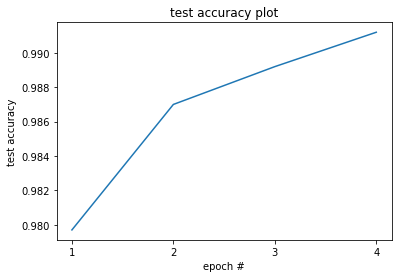

In [ ]:
##Exercise 3b ################################################
x = list(range(1, num_epochs + 1))
plt.plot(x, all_test_accuracy)
plt.ylabel('test accuracy')
plt.title('test accuracy plot')

plt.xlabel('epoch #')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

Text(0.5, 1.0, 'Trainning accuracy plot')

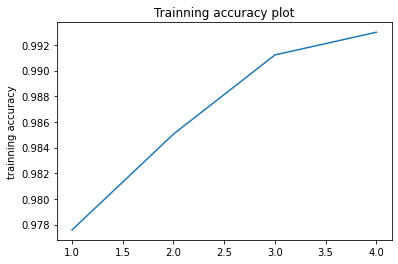

In [ ]:
plt.plot(x, all_train_accuracy)
plt.ylabel('trainning accuracy')
plt.title('Trainning accuracy plot')

Text(0.5, 1.0, 'Test loss plot')

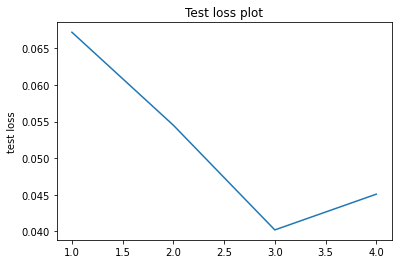

In [ ]:
plt.plot(x, all_test_loss)
plt.ylabel('test loss')
plt.title('Test loss plot')


Text(0.5, 1.0, 'Trainning loss plot')

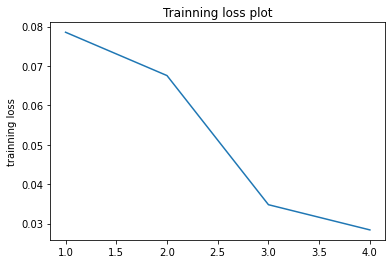

In [ ]:
plt.plot(x, all_train_loss)
plt.ylabel('trainning loss')
plt.title('Trainning loss plot')

In [ ]:
print(all_train_loss)
print(all_train_accuracy)
print(all_test_loss)
print(all_test_accuracy)

[0.07857571246128452, 0.06757529594226598, 0.03479598033488831, 0.028395378448294647]
[0.9775833333333334, 0.98505, 0.9912166666666666, 0.9929833333333333]
[0.06720361478587489, 0.054503101755057765, 0.04020137998793452, 0.04508404986897458]
[0.9797, 0.987, 0.9892, 0.9912]
